In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm_notebook
np.set_printoptions(suppress=True)
from sklearn import preprocessing
from tqdm import tqdm
import decimal
from itertools import combinations
from random import shuffle
from time import sleep
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
import gc
import datetime
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import os
from sklearn.metrics import roc_auc_score
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
import random
import lightgbm as lgb

In [2]:
#Always seed the randomness of this universe
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
seed_everything(seed=51)

In [4]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

In [5]:
train_dtypes = pd.read_csv('../input/train9_dtypes.csv')
test_dtypes = pd.read_csv('../input/test9_dtypes.csv')
train_dtypes.index = train_dtypes['TransactionID']
del train_dtypes['TransactionID']
test_dtypes.index = test_dtypes['TransactionID']
del test_dtypes['TransactionID']
train_dtypes = train_dtypes.iloc[:,0]
test_dtypes = test_dtypes.iloc[:,0]
print(type(train_dtypes),type(test_dtypes))
train_dtypes = train_dtypes.to_dict()
test_dtypes = test_dtypes.to_dict()
gc.collect()

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


21

In [6]:
%%time
train = pd.read_csv('../input/train9.csv',dtype= train_dtypes)
print("train finished")

train finished
CPU times: user 41.9 s, sys: 1.46 s, total: 43.3 s
Wall time: 43.4 s


In [7]:
%%time
test = pd.read_csv('../input/test9.csv',dtype= test_dtypes)
print("test finished")

test finished
CPU times: user 35.2 s, sys: 844 ms, total: 36 s
Wall time: 36 s


In [8]:
#sample_submission
sample_submission = pd.read_csv('../input/sample_submission.csv')
print(train.shape,test.shape,sample_submission.shape)

(590540, 556) (506691, 555) (506691, 2)


In [9]:
%%time
train_30eylul = pd.read_csv('../input/train_30eylul.csv')
print("train finished")

train finished
CPU times: user 3.96 s, sys: 48.1 ms, total: 4.01 s
Wall time: 4.01 s


In [10]:
%%time
test_30eylul = pd.read_csv('../input/test_30eylul.csv')
print("train finished")

train finished
CPU times: user 3.51 s, sys: 56 ms, total: 3.57 s
Wall time: 3.57 s


In [11]:
train_30eylul.drop(['uid3', 'TransactionAmt_check'],inplace=True,axis=1)
test_30eylul.drop(['uid3', 'TransactionAmt_check'],inplace=True,axis=1)

In [12]:
print(train.shape,test.shape,sample_submission.shape,train_30eylul.shape,test_30eylul.shape)

(590540, 556) (506691, 555) (506691, 2) (590540, 49) (506691, 49)


In [13]:
[x for x in train.columns if x in train_30eylul.columns]

['TransactionID']

In [14]:
train = train.merge(train_30eylul,how='left',on = 'TransactionID')

In [15]:
test = test.merge(test_30eylul,how='left',on = 'TransactionID')

In [16]:
print(train.shape,test.shape)

(590540, 604) (506691, 603)


In [17]:
train.head()

,TransactionID,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,uid,uid2,uid3,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,uid3_TransactionAmt_mean,uid3_TransactionAmt_std,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix,email_check,P_emaildomain_prefix,R_emaildomain_prefix,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day,device_name,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceInfo_fq_enc,device_name_fq_enc,id_30_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc,DT_M_total,DT_W_total,DT_D_total,uid_DT_M,uid_DT_W,uid_DT_D,C3,DeviceInfo_999999,DeviceInfo_Trident/7.0,DeviceType_mobile,Pemaildomain_mail.com,Pemaildomain_protonmail,ProductCD_DeviceInfo,Remaildomain_DeviceInfo,Remaildomain_lesscategory,Remaildomain_protonmail,TransactionAmt_decimal,V281,card1_addr1,card1_fraudulent,card2_fraudulent,card3_185.0,card3_DeviceInfo,card3_addr2,dayofyear_ischristmas,group10_kurtosis,group15_median,group4_sum,group5_kurtosis,group5_max,group5_mean,group5_median,group5_std,group6_max,group6_mean,group6_std,group7_max,hour_hourlist,id03subtractid04,id03sumid04,id05subtractid06,id09subtractid10,id09sumid10,id14_999999,id14_999999.0,id16is_null,id17_225.0,id18_15.0,id19_153.0,id19_321.0,id19_384.0,id19_427.0,id20_127.0,id20_325.0,id20_333.0,id20_401.0,id20_417.0,id20_507.0,id20_549.0,id20_597.0,id20_638.0,id31_999999,id31_firefox,id31_ie,id31_opera,id33_1280x720,id33_2208x1242,id33_secondframe,is_debit,Pemaildomain_DeviceInfo,ProductCD_card3,ProductCD_card5,ProductCD_dist2,V103,V295,V296,V309,card1_999999,dist1_108.0,dist1_86.0,group10_mean,group10_std,group10_sum,group12_mean,group12_sum,group15_max,group15_mean,group15_std,group4_kurtosis,group4_max,group6_sum,id07is_null,id19_216.0,id20is_null,id24is_null,id25is_

In [18]:
actual_imp_df = pd.read_csv('../input/actual_imp_df_train9.csv')
null_imp_df = pd.read_csv('../input/null_imp_df_train9.csv')
del actual_imp_df['Unnamed: 0']
del null_imp_df['Unnamed: 0']
actual_imp_df.columns = ['feature','real_gain','real_split']
gc.collect()

28

In [19]:
temp_gain = null_imp_df.groupby('feature')['importance_gain'].apply(list).reset_index(drop=False)
temp_gain = temp_gain.merge(actual_imp_df[['feature','real_gain']],how = 'left',on = 'feature')
temp_split = null_imp_df.groupby('feature')['importance_split'].apply(list).reset_index(drop=False)
temp_split = temp_split.merge(actual_imp_df[['feature','real_split']],how = 'left',on = 'feature')

In [20]:
column_name = 'importance_gain'
temp_gain['std'] = temp_gain[column_name].apply(np.std)
temp_gain['mean'] = temp_gain[column_name].apply(np.mean)
temp_gain['mean_minus_3_sd'] = temp_gain['mean'] - temp_gain['std']*3
temp_gain['mean_minus_2_std'] = temp_gain['mean'] - temp_gain['std']*2
temp_gain['mean_minus_1_std'] = temp_gain['mean'] - temp_gain['std']
temp_gain['mean_plus_1_std'] = temp_gain['mean'] + temp_gain['std']
temp_gain['mean_plus_2_std'] = temp_gain['mean'] + temp_gain['std']*2
temp_gain['mean_plus_3_std'] = temp_gain['mean'] + temp_gain['std']*3
temp_gain['quantiles'] = temp_gain[['real_gain','mean','mean_minus_3_sd','mean_minus_2_std','mean_minus_2_std',\
                                    'mean_plus_1_std','mean_plus_2_std','mean_plus_3_std']].values.tolist()
column_name = 'importance_split'
temp_split['std'] = temp_split[column_name].apply(np.std)
temp_split['mean'] = temp_split[column_name].apply(np.mean)
temp_split['mean_minus_3_sd'] = temp_split['mean'] - temp_split['std']*3
temp_split['mean_minus_2_std'] = temp_split['mean'] - temp_split['std']*2
temp_split['mean_minus_1_std'] = temp_split['mean'] - temp_split['std']
temp_split['mean_plus_1_std'] = temp_split['mean'] + temp_split['std']
temp_split['mean_plus_2_std'] = temp_split['mean'] + temp_split['std']*2
temp_split['mean_plus_3_std'] = temp_split['mean'] + temp_split['std']*3
temp_split['quantiles'] = temp_split[['real_split','mean','mean_minus_3_sd','mean_minus_2_std','mean_minus_2_std',\
                                    'mean_plus_1_std','mean_plus_2_std','mean_plus_3_std']].values.tolist()

In [21]:
temp_split.tail()

,feature,importance_split,real_split,std,mean,mean_minus_3_sd,mean_minus_2_std,mean_minus_1_std,mean_plus_1_std,mean_plus_2_std,mean_plus_3_std,quantiles
597,uid_DT_M,"[1655, 1676, 1728, 1634, 1705, 1651, 1749, 165...",1932,43.874681,1673.18,1541.555958,1585.430639,1629.305319,1717.054681,1760.929361,1804.804042,"[1932.0, 1673.18, 1541.5559581231453, 1585.430..."
598,uid_DT_W,"[1988, 1983, 2050, 2034, 1974, 2014, 1982, 208...",2293,44.453684,2007.90,1874.538949,1918.992632,1963.446316,2052.353684,2096.807368,2141.261051,"[2293.0, 2007.9, 1874.5389487144016, 1918.9926..."
599,uid_TransactionAmt_mean,"[1246, 1308, 1307, 1293, 1315, 1267, 1292, 133...",1508,41.171743,1296.74,1173.224772,1214.396515,1255.568257,1337.911743,1379.083485,1420.255228,"[1508.0, 1296.74, 1173.2247717890623, 1214.396..."
600,uid_TransactionAmt_std,"[728, 715, 814, 822, 753, 814, 760, 829, 784, ...",777,29.708914,772.02,682.893257,712.602171,742.311086,801.728914,831.437829,861.146743,"[777.0, 772.02, 682.8932565387919, 712.6021710..."
601,uid_fq_enc,"[1128, 1165, 1107, 1162, 1154, 1149, 1086, 112...",1347,31.657852,1144.98,1050.006444,1081.664296,1113.322148,1176.637852,1208.295704,1239.953556,"[1347.0, 1144.98, 1050.006443680359, 1081.6642..."


In [22]:
def find_region(x):
    real_ = x[0]
    mean = x[1]
    mean_minus_3_std = x[2]
    mean_minus_2_std = x[3]
    mean_minus_1_std = x[4]
    mean_plus_3_std = x[5]
    mean_plus_2_std = x[6]
    mean_plus_1_std = x[7]
    if (real_ < mean_minus_3_std):
        return -4
    elif (real_ < mean_minus_2_std) & (real_ > mean_minus_3_std ):
        return -3
    elif (real_ < mean_minus_1_std) & (real_ > mean_minus_2_std ):
        return -2
    elif (real_ < mean) & (real_ > mean_minus_1_std ):
        return -1
    elif (real_ > mean) & (real_ < mean_plus_1_std):
        return 1
    elif (real_ > mean_plus_1_std) & (real_ < mean_plus_2_std):
        return 2
    elif (real_ > mean_plus_2_std) & (real_ < mean_plus_3_std):
        return 3
    elif (real_ > mean_plus_3_std):
        return 4

In [23]:
temp_gain['region'] = temp_gain['quantiles'].apply(find_region)
temp_split['region'] = temp_split['quantiles'].apply(find_region)

In [24]:
temp_gain['region'].value_counts()

 4.0    198
 1.0    155
-4.0    112
-1.0    103
-3.0     33
Name: region, dtype: int64

In [25]:
temp_split['region'].value_counts()

 4.0    192
 1.0    174
-1.0    119
-4.0     83
-3.0     33
Name: region, dtype: int64

In [26]:
temp_split.head()

,feature,importance_split,real_split,std,mean,mean_minus_3_sd,mean_minus_2_std,mean_minus_1_std,mean_plus_1_std,mean_plus_2_std,mean_plus_3_std,quantiles,region
0,C1,"[402, 388, 416, 382, 366, 371, 401, 399, 392, ...",658,24.388522,401.60,328.434434,352.822956,377.211478,425.988522,450.377044,474.765566,"[658.0, 401.6, 328.434434328709, 352.822956219...",4.0
1,C10,"[59, 89, 70, 77, 80, 72, 88, 102, 98, 85, 94, ...",161,12.648178,82.94,44.995467,57.643645,70.291822,95.588178,108.236355,120.884533,"[161.0, 82.94, 44.99546679691526, 57.643644531...",4.0
2,C10_fq_enc,"[95, 94, 103, 86, 90, 93, 107, 92, 93, 88, 98,...",167,11.255861,100.16,66.392418,77.648279,88.904139,111.415861,122.671721,133.927582,"[167.0, 100.16, 66.39241791303381, 77.64827860...",4.0
3,C11,"[286, 285, 285, 281, 261, 297, 295, 271, 284, ...",467,21.092416,291.50,228.222753,249.315169,270.407584,312.592416,333.684831,354.777247,"[467.0, 291.5, 228.2227529043812, 249.31516860...",4.0
4,C11_fq_enc,"[320, 327, 275, 335, 315, 321, 312, 319, 331, ...",394,22.461175,317.34,249.956474,272.417649,294.878825,339.801175,362.262351,384.723526,"[394.0, 317.34, 249.9564738233446, 272.4176492...",4.0


In [27]:
temp_gain = temp_gain[['feature','region','real_gain']]
temp_gain2 = temp_gain.copy()
temp_gain = temp_gain[ temp_gain['region'] ==4 ]
temp_split = temp_split[['feature','region','real_split']]
temp_split2 = temp_split.copy()
temp_split = temp_split[ temp_split['region'] ==4 ]
temp_gain = temp_gain.reset_index(drop=True)
temp_split = temp_split.reset_index(drop=True)
print(temp_gain.shape,temp_split.shape)

(198, 3) (192, 3)


In [28]:
shared = [x for x in list(temp_gain['feature']) if x in list(temp_split['feature'])]
only_gain = [x for x in list(temp_gain['feature']) if x not in list(temp_split['feature'])]
only_split = [x for x in list(temp_split['feature']) if x not in list(temp_gain['feature'])]
print(len(shared),len(only_gain) , len(only_split))

123 75 69


In [29]:
print(shared)

['C1', 'C10', 'C10_fq_enc', 'C11', 'C11_fq_enc', 'C12', 'C12_fq_enc', 'C13', 'C14', 'C14_fq_enc', 'C1_fq_enc', 'C2', 'C2_fq_enc', 'C3', 'C4', 'C4_fq_enc', 'C6_fq_enc', 'C7', 'C8', 'C8_fq_enc', 'D13', 'DT_M', 'DeviceInfo', 'DeviceInfo_999999', 'DeviceInfo_fq_enc', 'DeviceType', 'DeviceType_mobile', 'M4', 'M5', 'M6', 'P_emaildomain', 'Pemaildomain_DeviceInfo', 'Pemaildomain_mail.com', 'Pemaildomain_outlook.com', 'Pemaildomain_protonmail', 'ProductCD', 'ProductCD_DeviceInfo', 'ProductCD_card3', 'ProductCD_card5', 'ProductCD_dist2', 'R_emaildomain', 'R_emaildomain_bin', 'R_emaildomain_prefix', 'Remaildomain_DeviceInfo', 'Remaildomain_icloud.com', 'Remaildomain_lesscategory', 'Remaildomain_protonmail', 'V149', 'V152', 'V154', 'V156', 'V187', 'V189', 'V198', 'V201', 'V243', 'V245', 'V248', 'V249', 'V252', 'V256', 'V257', 'V258', 'V259', 'V261', 'V281', 'V33', 'V34', 'V44', 'V45', 'V57', 'V58', 'V61', 'V62', 'V67', 'V79', 'V81', 'V82', 'V83', 'V86', 'V87', 'V94', 'card1_fraudulent', 'card2_fr

In [30]:
temp_split2[(temp_split2['feature'].isin(only_gain)) & (temp_split2['region'] >0.0)]

,feature,region,real_split
8,C13_fq_enc,1.0,816
22,C7_fq_enc,1.0,37
75,DeviceInfo_Trident/7.0,1.0,37
120,TransactionAmt_decimal_0.0,1.0,73
142,V140,1.0,35
156,V153,1.0,10
163,V16,1.0,6
175,V170,1.0,47
180,V175,1.0,15
186,V180,1.0,34


In [31]:
temp_gain2[(temp_gain2['feature'].isin(only_split)) & (temp_gain2['region'] >0.0)]

,feature,region,real_gain
30,C_nanstd,1.0,9590.322218
37,D14,1.0,1221.725152
56,D8,1.0,2797.489177
95,P_emaildomain_fq_enc,1.0,6636.945550
104,ProductCD_addr1,1.0,8830.312222
110,R_emaildomain_fq_enc,1.0,1565.356420
117,TransactionAmt,1.0,13413.403662
118,TransactionAmt_check,1.0,508.045310
119,TransactionAmt_decimal,1.0,5320.195963
124,TransactionAmt_to_mean_card4,1.0,13546.539847


In [32]:
print(only_gain)

['C13_fq_enc', 'C5', 'C7_fq_enc', 'C_nansum', 'DeviceInfo_Trident/7.0', 'TransactionAmt_decimal_0.0', 'V103', 'V138', 'V140', 'V153', 'V16', 'V170', 'V172', 'V175', 'V180', 'V188', 'V190', 'V192', 'V194', 'V199', 'V205', 'V220', 'V225', 'V227', 'V232', 'V237', 'V239', 'V244', 'V246', 'V251', 'V262', 'V266', 'V282', 'V283', 'V29', 'V294', 'V295', 'V296', 'V313', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326', 'V331', 'V47', 'V48', 'V54', 'V55', 'V66', 'V69', 'V70', 'V76', 'V85', 'V90', 'V91', 'V_nanmedian', 'addr2_fq_enc', 'card2_TransactionAmt_std', 'card3_TransactionAmt_std', 'card3_addr2', 'card3_count_full', 'card3_fq_enc', 'dist1_86.0', 'group15_max', 'group15_mean', 'group15_median', 'group4_std', 'group5_std', 'group6_sum', 'id09sumid10', 'id19_216.0', 'id33_firstframe', 'id_32']


In [33]:
print(only_split)

['C_nanstd', 'D14', 'D8', 'DT_D', 'DT_M_total', 'DT_W', 'DT_W_total', 'P_emaildomain_fq_enc', 'P_emaildomain_prefix', 'ProductCD_addr1', 'R_emaildomain_fq_enc', 'TransactionAmt', 'TransactionAmt_check', 'TransactionAmt_decimal', 'TransactionAmt_to_mean_card4', 'TransactionAmt_to_std_card4', 'V200', 'V215', 'V241', 'V253', 'V254', 'V255', 'V277', 'V278', 'V39', 'addr1', 'addr1_addr2', 'addr1_fq_enc', 'addr2', 'card1', 'card1_addr1', 'card1_count_full', 'card1_fq_enc', 'card2', 'card2_TransactionAmt_mean', 'card2_fq_enc', 'card4', 'device_name', 'group5_kurtosis', 'group6_max', 'group6_mean', 'group7_max', 'group9_std', 'id05subtractid06', 'id05sumid06', 'id09subtractid10', 'id13_27.0', 'id13_999999', 'id18_15.0', 'id19_153.0', 'id19_266.0', 'id19_384.0', 'id20_325.0', 'id_06', 'id_13', 'id_14', 'id_16', 'id_20', 'id_38', 'relative_hour', 'uid2', 'uid2_fq_enc', 'uid3_TransactionAmt_mean', 'uid3_TransactionAmt_std', 'uid3_fq_enc', 'uid4', 'uid_DT_M', 'uid_DT_W', 'uid_fq_enc']


In [34]:
all_columns = shared# + only_gain + only_split

In [35]:
print(len(all_columns))

123


In [36]:
print(all_columns)

['C1', 'C10', 'C10_fq_enc', 'C11', 'C11_fq_enc', 'C12', 'C12_fq_enc', 'C13', 'C14', 'C14_fq_enc', 'C1_fq_enc', 'C2', 'C2_fq_enc', 'C3', 'C4', 'C4_fq_enc', 'C6_fq_enc', 'C7', 'C8', 'C8_fq_enc', 'D13', 'DT_M', 'DeviceInfo', 'DeviceInfo_999999', 'DeviceInfo_fq_enc', 'DeviceType', 'DeviceType_mobile', 'M4', 'M5', 'M6', 'P_emaildomain', 'Pemaildomain_DeviceInfo', 'Pemaildomain_mail.com', 'Pemaildomain_outlook.com', 'Pemaildomain_protonmail', 'ProductCD', 'ProductCD_DeviceInfo', 'ProductCD_card3', 'ProductCD_card5', 'ProductCD_dist2', 'R_emaildomain', 'R_emaildomain_bin', 'R_emaildomain_prefix', 'Remaildomain_DeviceInfo', 'Remaildomain_icloud.com', 'Remaildomain_lesscategory', 'Remaildomain_protonmail', 'V149', 'V152', 'V154', 'V156', 'V187', 'V189', 'V198', 'V201', 'V243', 'V245', 'V248', 'V249', 'V252', 'V256', 'V257', 'V258', 'V259', 'V261', 'V281', 'V33', 'V34', 'V44', 'V45', 'V57', 'V58', 'V61', 'V62', 'V67', 'V79', 'V81', 'V82', 'V83', 'V86', 'V87', 'V94', 'card1_fraudulent', 'card2_fr

In [37]:
[x for x in all_columns if 'group' in x]

['group10_kurtosis', 'group5_mean', 'group5_median', 'group6_kurtosis']

In [38]:
[ x for x in [y for y in list(actual_imp_df['feature']) if 'group' in y] if x not in all_columns]

['group15_median',
 'group4_sum',
 'group5_kurtosis',
 'group5_max',
 'group5_std',
 'group6_max',
 'group6_mean',
 'group6_std',
 'group7_max',
 'group10_mean',
 'group10_std',
 'group10_sum',
 'group12_mean',
 'group12_sum',
 'group15_max',
 'group15_mean',
 'group15_std',
 'group4_kurtosis',
 'group4_max',
 'group6_sum',
 'group4_std',
 'group7_kurtosis',
 'group9_mean',
 'group9_std']

In [ ]:
"""
%%time
train[['TransactionID'] + all_columns].to_csv('../input/train_PI_1ekim.csv',index=False)
test[['TransactionID'] + all_columns].to_csv('../input/test_PI_1ekim.csv',index=False)
"""

In [39]:
dropped_columns = [x for x in ['TransactionID','TransactionDT','dayofyear','day'] if x in train.columns]

In [40]:
print(dropped_columns)

['TransactionID']


In [41]:
train.drop(dropped_columns,axis=1,inplace=True)
test.drop(dropped_columns,axis=1,inplace=True)
y = train['isFraud']
del train['isFraud']
gc.collect()
print(train.shape,test.shape,sample_submission.shape)

(590540, 602) (506691, 602) (506691, 2)


In [42]:
train = train[all_columns]
test = test[all_columns]
print(train.shape,test.shape,sample_submission.shape)
gc.collect()

(590540, 123) (506691, 123) (506691, 2)


14

# Training

In [43]:
########################### Model params
lgb_params = {'num_leaves': 546,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.1797454081646243,
          'bagging_fraction': 0.2181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3299927210061127,
          'reg_lambda': 0.3885237330340494,
          'random_state': 42,
}

In [44]:
N = 5
kf = KFold(n_splits=N)

importance = pd.DataFrame(np.zeros((train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=train.columns)
scores = []
y_pred = np.zeros(test.shape[0])
oof = np.zeros(train.shape[0])

for fold, (trn_idx, val_idx) in enumerate(kf.split(train, y), 1):
    print('Fold {}'.format(fold))
          
    trn_data = lgb.Dataset(train.iloc[trn_idx, :].values, label=y.iloc[trn_idx].values)
    val_data = lgb.Dataset(train.iloc[val_idx, :].values, label=y.iloc[val_idx].values)   
    
    #params, dtrain, 1600, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500
    clf = lgb.train(lgb_params, trn_data ,2000 ,valid_sets=[trn_data, val_data], verbose_eval=200,early_stopping_rounds=500)

    predictions = clf.predict(train.iloc[val_idx, :].values) 
    importance.iloc[:, fold - 1] = clf.feature_importance()
    oof[val_idx] = predictions

    score = roc_auc_score(y.iloc[val_idx].values, predictions)
    scores.append(score)
    print('Fold {} ROC AUC Score {}\n'.format(fold, score))

    y_pred += clf.predict(test) / N
    
    del trn_data, val_data, predictions
    gc.collect()
    
print('Average ROC AUC Score {} [STD:{}]'.format(np.mean(scores), np.std(scores)))

Fold 1
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.952846	valid_1's auc: 0.886312
[400]	training's auc: 0.97037	valid_1's auc: 0.899731
[600]	training's auc: 0.979664	valid_1's auc: 0.905926
[800]	training's auc: 0.985129	valid_1's auc: 0.908757
[1000]	training's auc: 0.988738	valid_1's auc: 0.910225
[1200]	training's auc: 0.991384	valid_1's auc: 0.911114
[1400]	training's auc: 0.99307	valid_1's auc: 0.911263
[1600]	training's auc: 0.994406	valid_1's auc: 0.911226
[1800]	training's auc: 0.99525	valid_1's auc: 0.911043
Early stopping, best iteration is:
[1450]	training's auc: 0.993484	valid_1's auc: 0.911486
Fold 1 ROC AUC Score 0.9114864588859568

Fold 2
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.952264	valid_1's auc: 0.908688
[400]	training's auc: 0.969532	valid_1's auc: 0.917576
[600]	training's auc: 0.979393	valid_1's auc: 0.921281
[800]	training's auc: 0.985472	valid_1's auc: 0.92389
[1000]	train

In [45]:
print(roc_auc_score(y,oof))

0.9237455262451897


In [46]:
importance['avg'] = importance.mean(axis=1)

In [47]:
importance = importance.sort_values(by='avg',ascending=False)

In [48]:
importance = importance.reset_index(drop=False)

In [49]:
importance

,index,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg
0,uid3,59031,46707,44041,50255,47398,49486.4
1,uid2_TransactionAmt_mean,56864,46347,46479,50444,47110,49448.8
2,uid_TransactionAmt_mean,57922,43560,39952,48745,43729,46781.6
3,C13,26455,21834,20851,24071,22422,23126.6
4,Pemaildomain_DeviceInfo,25124,20414,24591,21763,20371,22452.6
5,group6_kurtosis,22192,18225,18641,19301,18179,19307.6
6,ProductCD_card5,20486,15962,18756,18411,15916,17906.2
7,P_emaildomain,19980,16069,16523,16669,15907,17029.6
8,C2,19320,14795,15825,16034,14477,16090.2
9,card5_TransactionAmt_mean,17173,14515,16737,15383,14366,15634.8


In [50]:
importance.to_csv('../importances/importances28.csv',index=False)

In [51]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [52]:
sample_submission['isFraud'] = y_pred

In [53]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.001359
1,3663550,0.002010
2,3663551,0.001919
3,3663552,0.000892
4,3663553,0.001760


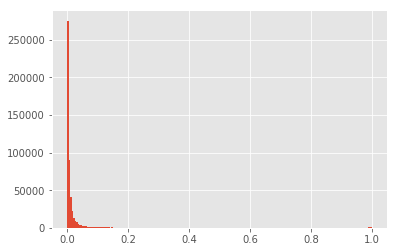

In [54]:
plt.hist(sample_submission['isFraud'],bins=200)
plt.show()

In [55]:
sample_submission.to_csv('../predictions/pred28.csv',index=False)

In [56]:
!kaggle competitions submit -c ieee-fraud-detection -f ../predictions/pred28.csv -m "pred28"

100%|███████████████████████████████████████| 14.1M/14.1M [00:33<00:00, 447kB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [57]:
importances = pd.read_csv('../importances/importances27.csv')

In [58]:
importances

,index,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg
0,relative_hour,29346,12207,13466,13951,18938,17581.6
1,uid3_TransactionAmt_mean,25090,12737,13079,14249,20507,17132.4
2,DT_D,28239,12239,11445,13762,18464,16829.8
3,uid3_fq_enc,26674,13262,10815,14997,17511,16651.8
4,uid3,25548,13718,11635,14579,16760,16448.0
5,uid_DT_M,25075,11090,10272,13216,16639,15258.4
6,uid3_TransactionAmt_std,23398,11418,11560,12226,16977,15115.8
7,uid_DT_W,24995,11010,10443,12049,16174,14934.2
8,TransactionAmt_to_mean_card4,23592,10148,11108,12177,15732,14551.4
9,TransactionAmt_to_std_card4,24692,10066,8471,11687,16917,14366.6
